<a href="https://colab.research.google.com/github/daniel-hu-37/thesis/blob/main/scripts/thesis_ilqr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cartpole Problem

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x & \dot{x} & \theta & \dot{\theta}
    \end{bmatrix}^T
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x}
    \end{bmatrix}^T
\end{equation*}
$$

The goal is to swing the pendulum upright:

$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0 & 0 & 0
    \end{bmatrix}^T
\end{equation*}
$$

**Note**: The force is constrained between $-1$ and $1$. This is achieved by
instead fitting for unconstrained actions and then applying it to a squashing
function $\tanh(\textbf{u})$. This is directly embedded into the dynamics model
in order to be auto-differentiated. This also means that we need to apply this
transformation manually to the output of our iLQR at the end.

In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

In [231]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    # print("xs", xs)
    avg_cost = np.sum([(abs(x[2]) - np.pi)**2 for x in xs])
    # avg_cost += np.sum([u**2 for u in us])
    avg_cost /= len(xs)
    print(avg_cost)
    avg_costs.append(avg_cost)
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = xs[-1]
    print("iteration", iteration_count, info, J_opt, final_state)

In [10]:
!pip install --force-reinstall git+https://github.com/daniel-hu-37/neural_ilqr.git

  Cloning https://github.com/daniel-hu-37/neural_ilqr.git to /tmp/pip-req-build-3qdjw4hn
  Running command git clone --filter=blob:none --quiet https://github.com/daniel-hu-37/neural_ilqr.git /tmp/pip-req-build-3qdjw4hn
  Resolved https://github.com/daniel-hu-37/neural_ilqr.git to commit 7a7461a20b4786236f30e0a8b62351451e39d73f
  Preparing metadata (setup.py) ... done
  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Using cached scipy-1.13.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.6 MB)
  Using cached jax-0.4.26-py3-none-any.whl (1.9 MB)
  Using cached jaxlib-0.4.26-cp310-cp310-manylinux2014_x86_64.whl (78.8 MB)
  Using cached ml_dtypes-0.4.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.2 MB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Created wheel for neural-ilqr: filename=neural_ilqr-1.0-py3-none-any.whl size=21513 sha256=fdcc12cbf01240eebd505eadc2df274ddb517f0d95f60d75783ec05c54

In [43]:
from neural_ilqr.ilqr.controller import iLQR
from neural_ilqr.ilqr.cost import QRCost
from neural_ilqr.models.cartpole import CartpoleDynamics

In [241]:
dt = 0.02
pole_length = 1.0
dynamics = CartpoleDynamics(l=pole_length, min_bounds=-1.0, max_bounds=1.0)

In [242]:
# Note that the augmented state is not all 0.
x_goal = np.array([0.0, 0.0, 0.0, 0.0])

# Instantenous state cost.
Q = np.eye(dynamics.dim_state)
Q[0, 0] = 1.0
Q[1, 1] = Q[3, 3] = 0.0
Q[0, 2] = Q[2, 0] = pole_length
Q[2, 2] = pole_length**2
R = 0.1 * np.eye(dynamics.dim_control)

# Terminal state cost.
Q_terminal = 100 * np.eye(dynamics.dim_state)

# Instantaneous control cost.
R = np.array([[0.1]])

cost = QRCost(Q, R, Q_terminal=Q_terminal, x_goal=x_goal)

In [265]:
N = 20
x0 = np.array([0.0, 0.0, np.pi, 0.0])
us_init = np.random.uniform(-1, 1, (N, dynamics.dim_control))
ilqr = iLQR(dynamics, cost, N)

In [266]:
J_hist = []
avg_costs = []
xs, us = ilqr.fit(x0, us_init, n_iterations=500, on_iteration=on_iteration)

0.00022523204157720483
iteration 0 accepted 1168.9515047914301 [-0.05367    -0.02924202  3.12085271  0.06030903]
0.0002276962643843819
iteration 1 accepted 1168.779934256267 [-0.05390769 -0.02939721  3.12057376  0.06034384]
0.00023020365933833762
iteration 2 accepted 1168.6082938490913 [-0.05414565 -0.02955373  3.12029457  0.06037989]
0.0002327327360201663
iteration 3 accepted 1168.4367354273809 [-0.05438412 -0.02970932  3.12001538  0.0604143 ]
0.0002327327360201663
iteration 4 failed 1168.4367354273809 [-0.05438412 -0.02970932  3.12001538  0.0604143 ]
0.0002327327360201663
iteration 5 failed 1168.4367354273809 [-0.05438412 -0.02970932  3.12001538  0.0604143 ]
0.0002327327360201663
iteration 6 failed 1168.4367354273809 [-0.05438412 -0.02970932  3.12001538  0.0604143 ]
0.0002327327360201663
iteration 7 failed 1168.4367354273809 [-0.05438412 -0.02970932  3.12001538  0.0604143 ]
0.0002327327360201663
iteration 8 failed 1168.4367354273809 [-0.05438412 -0.02970932  3.12001538  0.0604143 ]
0

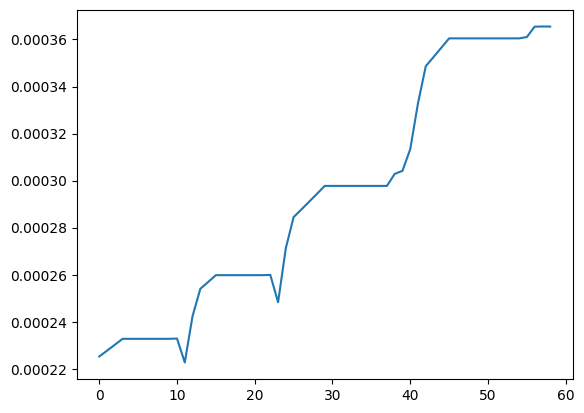

In [267]:
plt.plot(avg_costs)

In [ ]:
# Reduce the state to something more reasonable.
# xs = dynamics.reduce_state(xs)

# Constrain the actions to see what's actually applied to the system.
# us = constrain(us, dynamics.min_bounds, dynamics.max_bounds)

In [33]:
t = np.arange(N + 1) * dt
x = xs[:, 0]
x_dot = xs[:, 1]
theta = np.unwrap(xs[:, 2])  # Makes for smoother plots.
theta_dot = xs[:, 3]

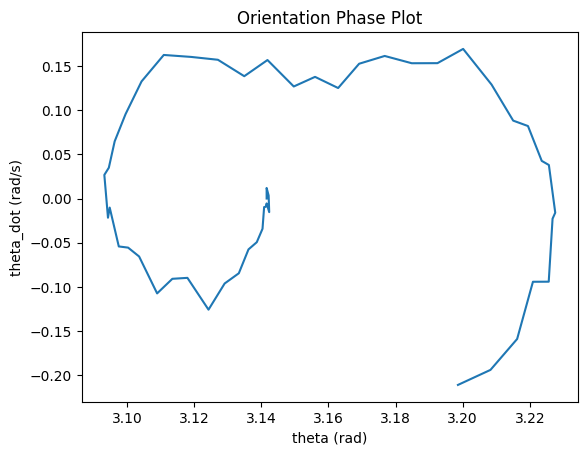

In [35]:
_ = plt.plot(theta, theta_dot)
_ = plt.xlabel("theta (rad)")
_ = plt.ylabel("theta_dot (rad/s)")
_ = plt.title("Orientation Phase Plot")

In [ ]:
_ = plt.plot(t, theta)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Orientation (rad)")
_ = plt.title("Orientation path")

In [ ]:
_ = plt.plot(t[:-1], us)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Force (N)")
_ = plt.title("Action path")

In [ ]:
_ = plt.plot(t, x)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Position (m)")
_ = plt.title("Position path")

In [ ]:
_ = plt.plot(t, x_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Velocity (m)")
_ = plt.title("Velocity path")

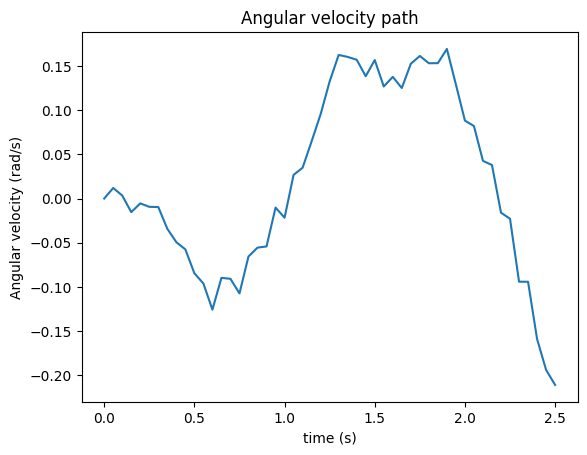

In [34]:
_ = plt.plot(t, theta_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Angular velocity (rad/s)")
_ = plt.title("Angular velocity path")

In [ ]:
_ = plt.plot(J_hist)
_ = plt.xlabel("Iteration")
_ = plt.ylabel("Total cost")
_ = plt.title("Total cost-to-go")